In [1]:
import torch
import torch.nn.functional as F
from torch.distributions.normal import Normal
from datasets import load_dataset
import os
from transformer_lens import utils, HookedTransformer
from datasets.arrow_dataset import Dataset
from sae_vis.model_fns import AutoEncoder, AutoEncoderConfig
from sae_vis.data_storing_fns import SaeVisData
from sae_vis.data_config_classes import SaeVisConfig
import matplotlib.pyplot as plt

from main import SparseAutoencoder, input_dim, expansion_factor, tokenizer, hook_point, model

torch.set_grad_enabled(False);

/Users/joel/code/sae_expected_l0/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/joel/code/sae_expected_l0/.venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/Users/joel/code/sae_expected_l0/.venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. 

Loaded pretrained model roneneldan/TinyStories-1M into HookedTransformer


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [2]:
state_dict = torch.load("/Users/joel/Downloads/sae (1).pth", map_location=torch.device('cpu'))

In [3]:
l0_coefficient = 0.01414
stddev_prior = 32.328
normal = Normal(0, 1)

In [4]:
sae = SparseAutoencoder(input_dim=input_dim, hidden_dim=input_dim*expansion_factor, stddev_prior=stddev_prior)
sae.load_state_dict(state_dict)

<All keys matched successfully>

In [5]:
tokens = tokenizer("hello, world")["input_ids"]
output, cache = model.run_with_cache(
    torch.tensor(tokens, device="cpu"), remove_batch_dim=True
)
x = cache[hook_point]

In [18]:
def histogram(arr, title=''):
    plt.hist(arr.flatten().cpu().detach().numpy(), bins=50, alpha=0.75, color='blue')
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

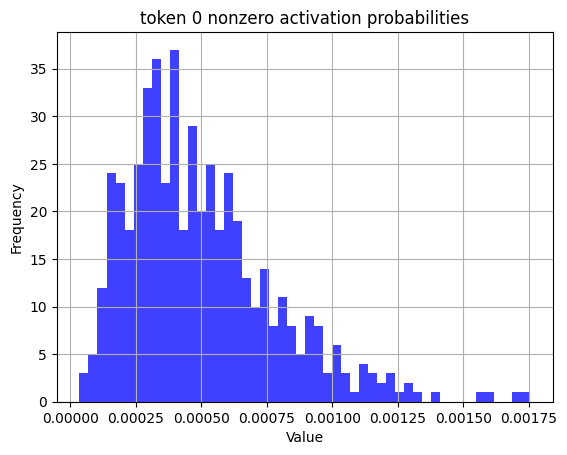

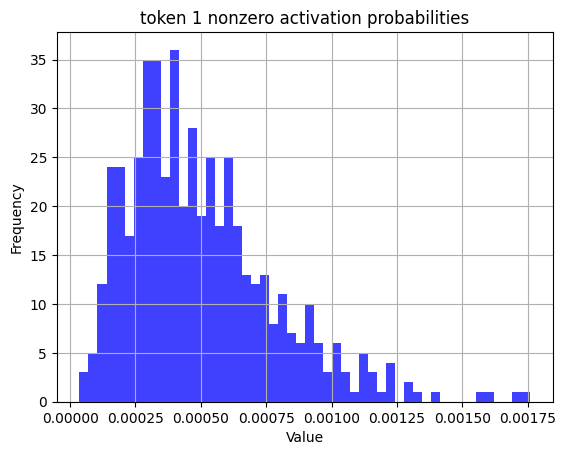

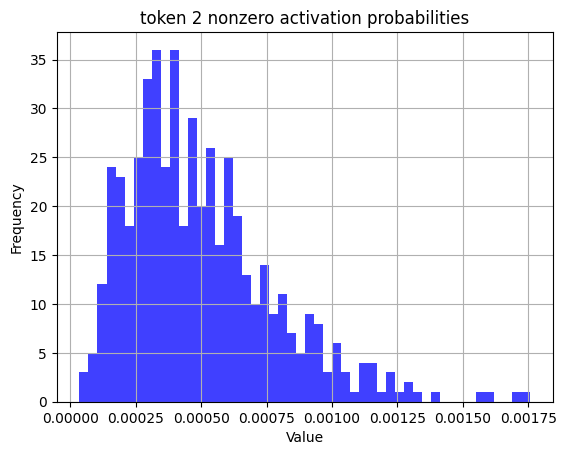

In [45]:
def token_non_zero_hist(i):
    x_hat, pre_activation = sae(x[i])
    stddevs = stddev_prior * torch.sqrt((sae.encoder.weight**2).sum(dim=1))
    prob_non_zero = 1 - normal.cdf(-pre_activation / stddevs)
    histogram(prob_non_zero, f"token {i} nonzero activation probabilities")

for i in range(3):
    token_non_zero_hist(i)

In [23]:
new_state_dict = {
    "W_enc": state_dict["encoder.weight"].T,
    "b_enc": state_dict["encoder.bias"],
    "W_dec": state_dict["decoder.weight"].T,
    "b_dec": state_dict["decoder.bias"],
}

In [25]:
d_hidden, d_in = state_dict["encoder.weight"].shape
cfg = AutoEncoderConfig(d_in=d_in, d_hidden=d_hidden)
encoder = AutoEncoder(cfg)
encoder.load_state_dict(new_state_dict)

for k, v in encoder.named_parameters():
    print(f"{k}: {tuple(v.shape)}")

W_enc: (64, 512)
W_dec: (512, 64)
b_enc: (512,)
b_dec: (64,)


In [26]:
SEQ_LEN = 128

# Load in the data (it's a Dataset object)
data = load_dataset("roneneldan/TinyStories", split="train")
assert isinstance(data, Dataset)

# Tokenize the data (using a utils function) and shuffle it
tokenized_data = utils.tokenize_and_concatenate(data, model.tokenizer, max_length=SEQ_LEN) # type: ignore
tokenized_data = tokenized_data.shuffle(42)

# Get the tokens as a tensor
all_tokens = tokenized_data["tokens"]
assert isinstance(all_tokens, torch.Tensor)

print(all_tokens.shape)

torch.Size([3714797, 128])


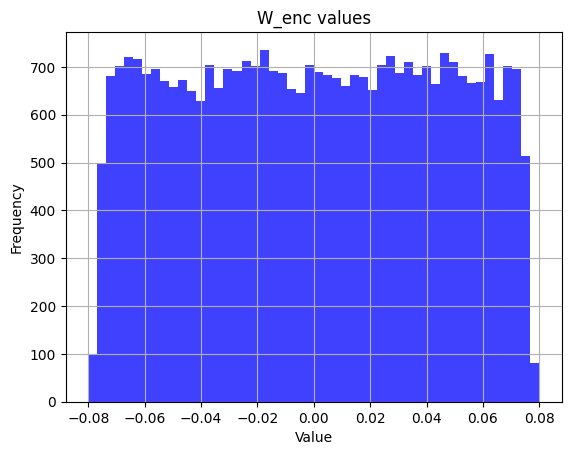

In [38]:
histogram(encoder.W_enc, 'W_enc values')

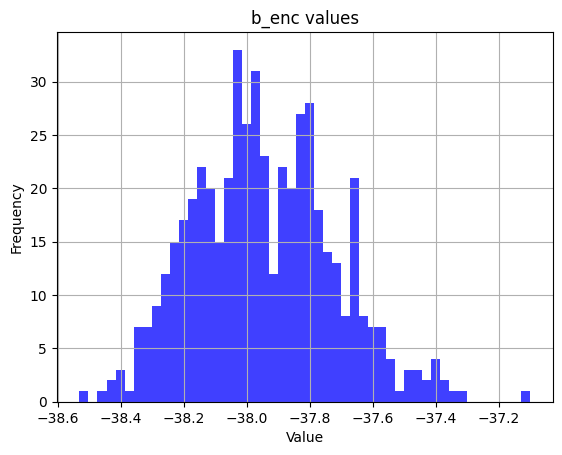

In [40]:
histogram(encoder.b_enc, 'b_enc values')

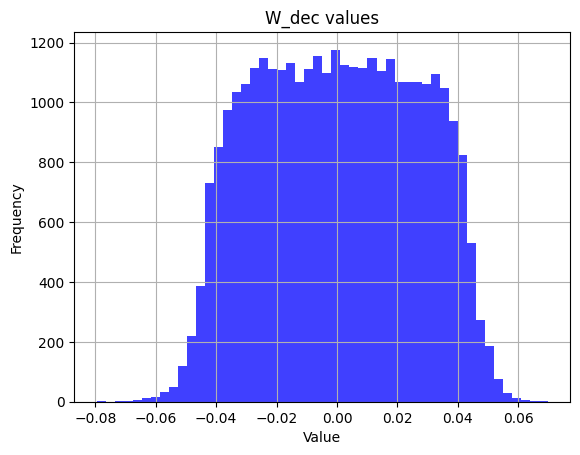

In [41]:
histogram(encoder.W_dec, 'W_dec values')

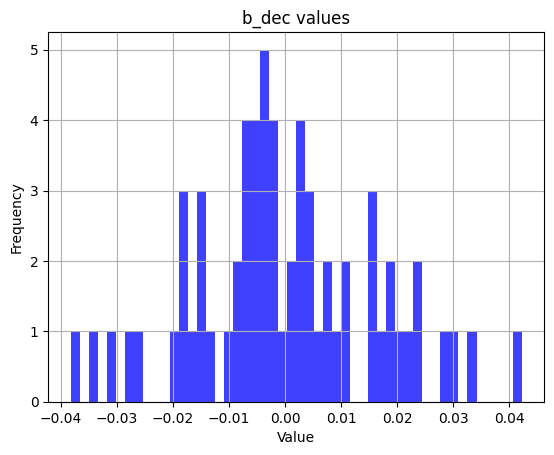

In [42]:
histogram(encoder.b_dec, 'b_dec values')

In [36]:
encoder.to("cpu")

AutoEncoder(d_in=64, dict_mult=8)

In [46]:
sae_vis_config = SaeVisConfig(
    hook_point = "blocks.4.hook_resid_post",
    features = range(64),
    verbose = True,
)

# Gather the feature data
sae_vis_data = SaeVisData.create(
    encoder = encoder,
    model = model,
    tokens = all_tokens[:2048],
    cfg = sae_vis_config,
)

filename = "feature_vis.html"
sae_vis_data.save_feature_centric_vis(filename, feature_idx=8)

Extracting vis data from cached data: 100%|██████████████████████████| 64/64 [01:07<00:00,  6.63it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ Task                                           ┃ Time   ┃ Pct % ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ (1) Initialization                             │ 0.07s  │ 0.1%  │
│ (2) Forward passes to gather model activations │ 57.02s │ 83.6% │
│ (3) Computing feature acts from model acts     │ 0.27s  │ 0.4%  │
│ (4) Getting data for tables                    │ 0.02s  │ 0.0%  │
│ (5) Getting data for histograms                │ 0.49s  │ 0.7%  │
│ (6) Getting data for sequences                 │ 9.98s  │ 14.6% │
│ (7) Getting data for quantiles                 │ 0.31s  │ 0.5%  │
└────────────────────────────────────────────────┴────────┴───────┘

Saving feature-centric vis: 100%|████████████████████████████████████| 64/64 [00:00<00:00, 72.82it/s]
